## Final Project Submission

Please fill out:
* Student name: Kevin Spring
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:

# Business Problem
Our clients is a residential real estate broker in King County, WA interested in finding a solution for their clients. Many of their customers come to them needing to sell their home but are unsure of the listing price. The client wants us to design and implement a model where they can take in the attributes of their seller's home and determine which price to begin listing discussion.

# Stakeholders
- President of brokerage firm
- Real estate agents that will use the dashboard

# Methods

In [1]:
# Import libraries
from datetime import date

## Data analysis
import pandas as pd
import numpy as np

## Statistical analysis
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf  
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

## Model Building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import data
df = pd.read_csv('data/kc_house_data.csv')

# Data

## Description

The data is a collection of single family homes in the King County, WA area sold between May 2014 and May 2015. The data contains 20 variables and 21,597 records. This data will be suitable to create a model to predict sale price for homes within the paramaters of this dataset.

In [2]:
# import and inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Variable Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


# Clean Data
## Identify and remove duplicated records

In [3]:
# Any dulplicated homes?
duplicates_len = len(df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id'))
print(f"There are {duplicates_len} duplicated records.")
df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id').head(4)
#df[df['id'] == 1000102]

There are 353 duplicated records.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.0,2400,9373,2.0,NO,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
2494,1000102,9/16/2014,280000.0,6,3.0,2400,9373,2.0,NaN,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,10/16/2014,150000.0,2,1.0,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,4/24/2015,175000.0,2,1.0,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969


### Duplicate home ID discussion
The duplicated records based on ID  are from the same homes that sold within the same year as they have the same attributes except for sale `date`. These may be homes that were flipped or sold quickly after an inintial sale. I will keep these records as I am interested in predicting a home's sale price and these sales of the same home can act as replicates improving my model.

## Remove Unnecessary variables
The following variables will be deleted from this analysis as they are unnecessary
- `id` - This is an unique identifier for each home. As it is too specific it will be deleted.
- `date` - This is the sale date and is not needed as all the homes were sold between 2014 to 2015.
- `lat` - This is the latitude of the home sold. As it is too specific for the home it will be deleted
- `long` - same reasoning as `lat`

In [4]:
df.drop(['id','date', 'lat', 'long'], axis=1, inplace=True)

## Identify Missing data

In [5]:
# How many columns have NaN?
print(df.isna().sum())

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [6]:
# Any placeholders?
# Look for top occuring values
print('King County, WA \n Home Sales Dataframe\n')
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize = True).head(10), '\n')

King County, WA 
 Home Sales Dataframe

price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
325000.0    0.006853
400000.0    0.006714
375000.0    0.006390
300000.0    0.006158
525000.0    0.006066
Name: price, dtype: float64 

bedrooms 
 3     0.454878
4     0.318655
2     0.127796
5     0.074131
6     0.012594
1     0.009075
7     0.001760
8     0.000602
9     0.000278
10    0.000139
Name: bedrooms, dtype: float64 

bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
1.50    0.066907
2.75    0.054869
3.00    0.034866
3.50    0.033847
3.25    0.027272
Name: bathrooms, dtype: float64 

sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
1800    0.005973
1820    0.005927
1480    0.005788
1720    0.005788
1540    0.005742
Name: sqft_living, dtype: float64 

sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
750

### Missing value results
- `NaN`
    - `waterfront`
        - Binary categorical variable (`YES` or `NO`)
        - replace `NaN` with mode of `NO` as most likely these properties are not waterfront
    - `view`
        - Ordinal categorical variable
        - replace `NaN` with `NONE` 
    - `yr_renovated`
        - Will be converted to a countable numerical variable
        - `0` is the most common value with over 95% of values. 
        - Replace `NaN` with 0 value
- Placeholder
    - `yr_renovated` has `0` for missing or unknown values.
    - `sqft_basement` has `?` for missing or unknown values.

In [7]:
# replacing waterfront NaN with 'NO'
df['waterfront'].fillna('NO', inplace=True)

# replace yr_renovated NaN with 'Unknown'
df['yr_renovated'].fillna(0, inplace=True)

# replace `Nan` with `NONE` for column `view`
df['view'].fillna('NONE', inplace=True)

In [8]:
# Confirm no more NaN values
print(df.isna().sum())

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64


## Coding ordinal, binary, and count data
- `condition`
    - Ordinal categorical variable
    - dictionary - `{'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}`
- `grade`
    - Ordinal categorical variable
    - Example: `7 Average`
    - Delete the descriptor, keep the number, and convert it to `int` datatype
- `sqft_basement`
    - Code to binary catagorical ('No': 0, 'Yes':1)
    - `?` makes up about 2% of values and the current value of `0` makes up almost 60%
    - Since 2% is a low value I will replace `?` with the mode of `0`
    - If there is a basement (sq.ft > 0) the value will be set to `1`
- `view`
    - Oridinal catagorical variable
    - dicitonary - `{'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}`
- `waterfront`
    - Binary catagorical variable
    - dictionary - `'NO': 0, 'YES': 1`
- `home_age`
    - Create new count variable
    - subtract current year from `yr_built`
    - Drop `yr_built`
- `yr_since_reno`
    - Make new count variable  
    - Subtract current year from `yr_renovated`
        -  `0` is the most common value with over 95% of values.
        - if never renovated then subtract from `yr_built`
    - Drop `yr_renovated`

In [9]:
# Encoding ordinal, binary, and count variables

# condition: Map condition variable to dictionary
condition_dict = {'Poor': 0, 'Fair': 1, 'Average': 2, 
                  'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(condition_dict)

# grade: strip out by spaces and keep the first string, which should be the number
df['grade'] = df['grade'].apply(lambda x: x.split(' ', 1)[0]).astype(int)

# sqft_basement has '?' as a placeholder. Set this to 0.
df['sqft_basement'].replace('?', 0, inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['sqft_basement'].loc[df['sqft_basement'] > 0] = 1
df.rename(columns={'sqft_basement': 'basement'}, inplace=True)

# view: Map ordinal variable to dictionary
view_dict = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 
                  'GOOD': 3, 'EXCELLENT': 4}
df['view'] = df['view'].map(view_dict)
df.head()

# waterfront: Map binary variable to dictionary
waterfront_dict = {'NO': 0, 'YES': 1}
df['waterfront'] = df['waterfront'].map(waterfront_dict)

# home_age: Calculate home age using current year
current_year = date.today().year
df['home_age'] = current_year - df['yr_built']
df.drop('yr_built', axis=1, inplace=True)

# yr_since_reno
# subtraction function
def sub(a, b):
    return a - b

df['yr_since_reno'] = df.apply(lambda row : sub(current_year, row['yr_renovated']) if row['yr_renovated'] > 0 else row['home_age'], axis = 1)
df.drop('yr_renovated', axis=1, inplace=True)


/home/kevinspring/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Outliers
There are some outliers that may be due to data entry problems. One home has 33 bedroom. I was expecting it to be a mansion but it has an average grade (7), 1.75 bathrooms, and only 1,620 square feet of living space. I think this house had a miskey and the number of bedrooms should be 3.

In [10]:
df[df['bedrooms'] > 30]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,zipcode,sqft_living15,sqft_lot15,home_age,yr_since_reno
15856,640000.0,33,1.75,1620,6000,1.0,0,0,4,7,1040,1.0,98103,1330,4700,75,75.0


In [11]:
df.at[15856, 'bedrooms'] = 3
df.loc[[15856]]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,zipcode,sqft_living15,sqft_lot15,home_age,yr_since_reno
15856,640000.0,3,1.75,1620,6000,1.0,0,0,4,7,1040,1.0,98103,1330,4700,75,75.0


# Exploratory Data Analysis
## Cleaned Data Description

In [12]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,zipcode,sqft_living15,sqft_lot15,home_age,yr_since_reno
count,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597
mean,540297,3.37181,2.11583,2080.32,15099.4,1.4941,0.0067602,0.233181,2.40983,7.65792,1788.6,0.3851,98078,1986.62,12758.3,51.0003,49.0549
std,367368,0.904096,0.768984,918.106,41412.6,0.539683,0.0819439,0.764673,0.650546,1.1732,827.76,0.48663,53.5131,685.23,27274.4,29.3752,28.9454
min,78000,1,0.5,370,520,1,0,0,0,3,370,0,98001,399,651,7,7
25%,322000,3,1.75,1430,5040,1,0,0,2,7,1190,0,98033,1490,5100,25,23
50%,450000,3,2.25,1910,7618,1.5,0,0,2,7,1560,0,98065,1840,7620,47,45
75%,645000,4,2.5,2550,10685,2,0,0,3,8,2210,1,98118,2360,10083,71,68
max,7.7e+06,11,8,13540,1.65136e+06,3.5,1,4,4,13,9410,1,98199,6210,871200,122,122


## About the data
The median house sold in King County, WA between 2014 to 2015 was for \$450,000. It median house was 1910 square feet, 3 bedroom, 2.25 bathrooms, and 47 years old. The minimum home sale price is \\$78,000 and the maximum home sale price is \\$7,700,000.

### Scatter matrix to identify highly independent variables correlated with price

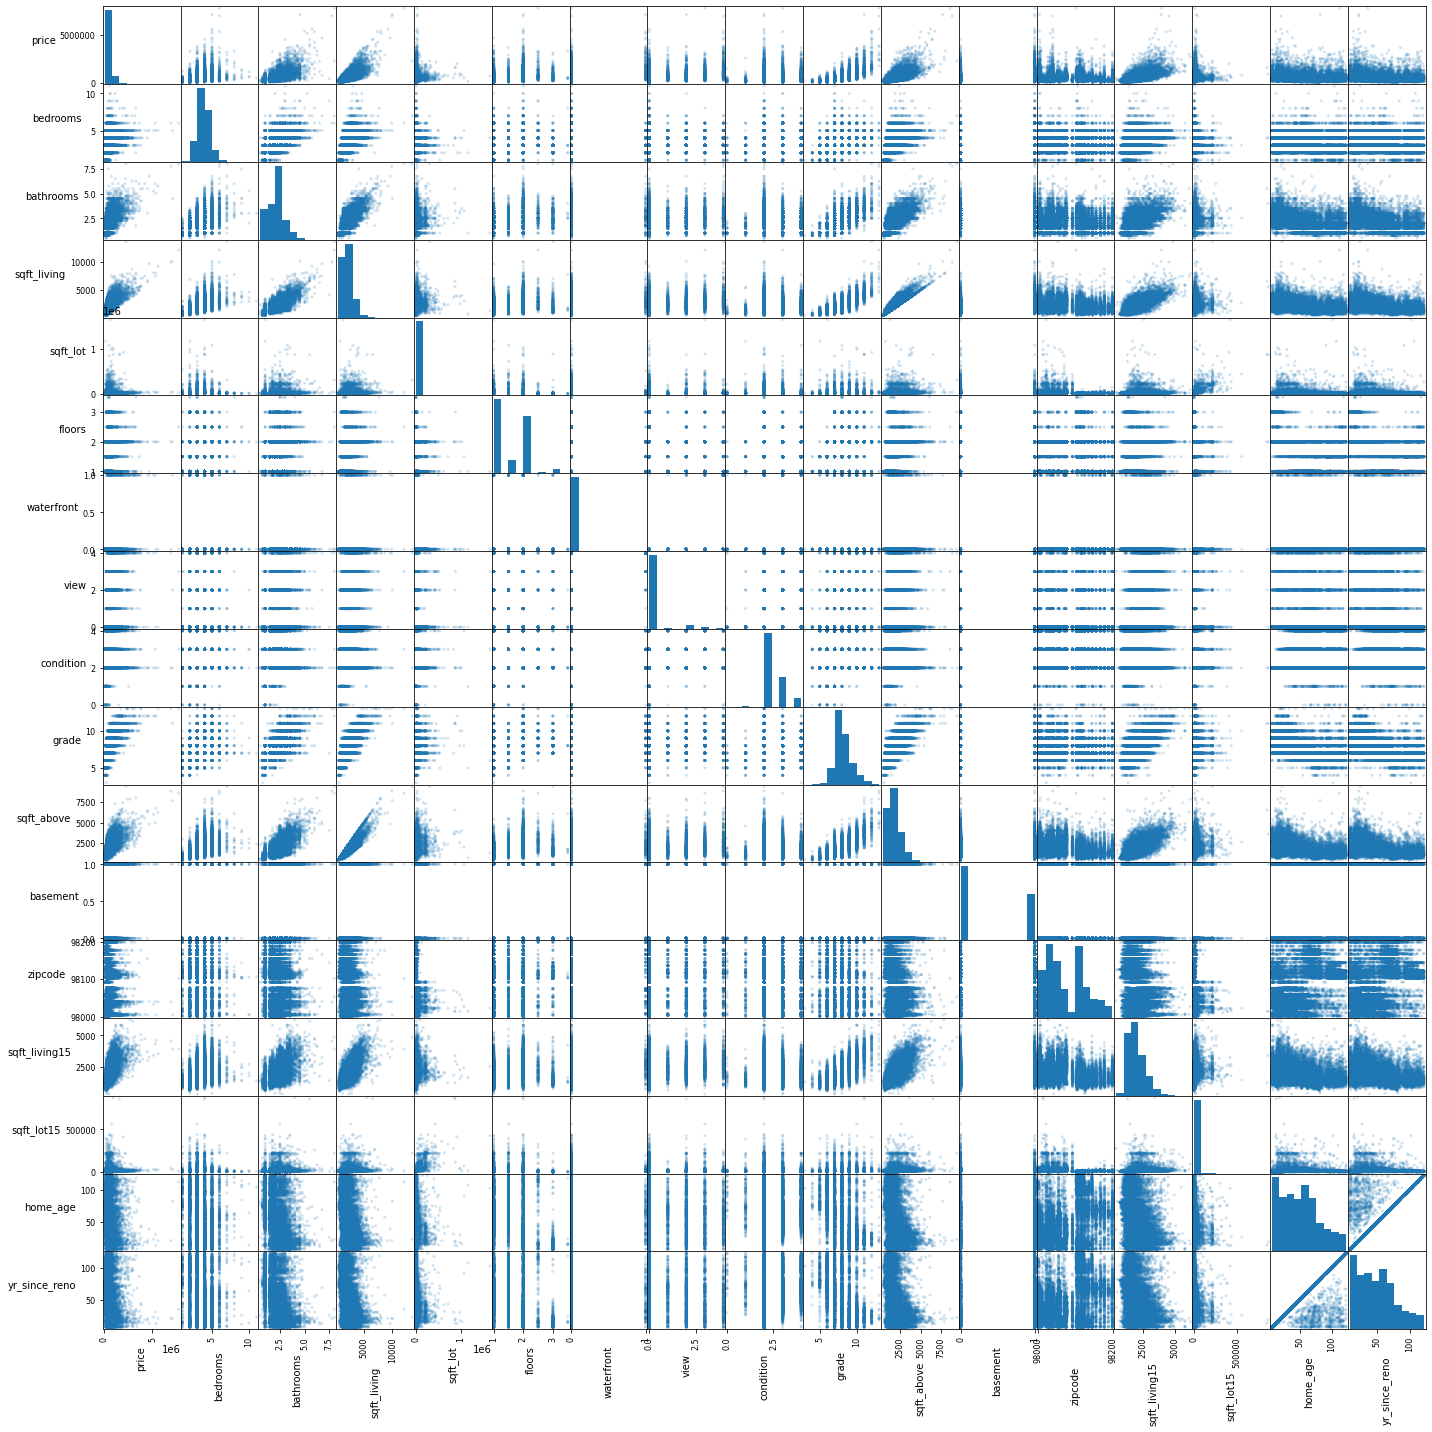

In [13]:
# Visualize the data using scatter plot and histogram

import warnings
warnings.filterwarnings('ignore')

axes = pd.plotting.scatter_matrix(df, alpha = 0.2, figsize  = [20, 20])
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


### Scatter Matrix Results

#### Histogram
The histograms indicate that most of the variables are right-skewed, including the dependent variable, price. 

#### Scatterplot
The variables with obvious positive coorelation with price has to do with the number of bathrooms, grade, and square footage of the living space in the home.

### Correlation Matrix Heatmap

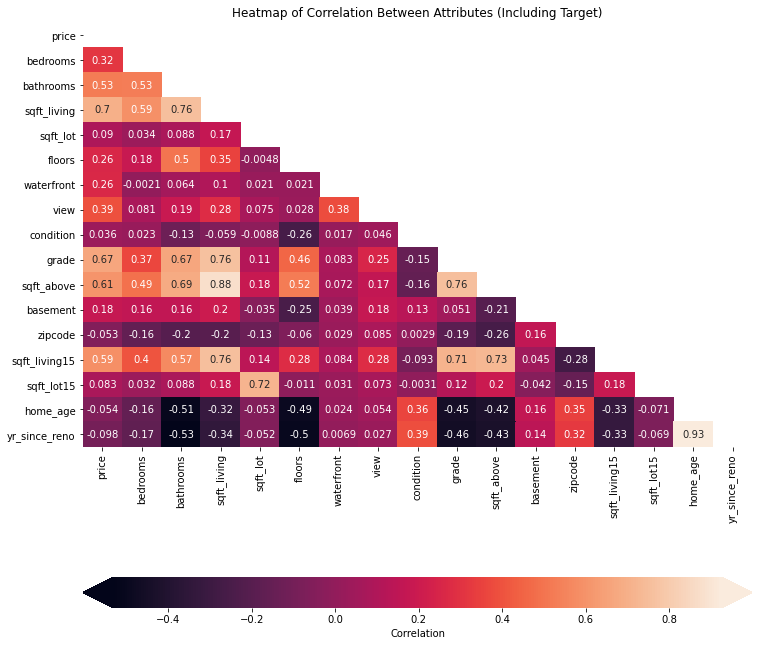

In [14]:
# Make heatmap 

# compute the correlation matrix
corr = df.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [15]:
# Convert zipcode variable to Dummy variables
df_clean = df.copy()
cat_col = ['zipcode']

# label columns as category
df[cat_col] = df[cat_col].astype('category')
ohe_df = pd.get_dummies(df[cat_col], drop_first=True)

# merge ohe_df with df_clean and drop old zip_code column
df_clean = pd.concat([df_clean, ohe_df], axis=1)
df_clean.drop(cat_col, axis=1, inplace=True)

# Model Specification
In this section I will specify which variable to include in the model to predict sales price. After checking the assumptions and correcting errors, I will start building the first model (M1) using variables highly correlated with sale price. For model 2 (M2) I use a stepwise regression to choose variables but find that this method chooses all variables, including the dummy variables for the zipcode. Finally, in model 3 (M3) I will add interaction effects to M1.  

In [16]:
# Features correlated 
features = []
correlations = []
for idx, correlation in corr['price'].T.iteritems():
    if correlation >= .6 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})

print('Variables correlated with Price')
display(corr_with_price)

Variables correlated with Price


,Correlations,Features
0,0.701917,sqft_living
1,0.667951,grade
2,0.605368,sqft_above


## Check assumptions
[Source](https://www.albert.io/blog/key-assumptions-of-ols-econometrics-review/)

### Assumption 1
The regression model is linear in the coefficients and error term

### Assumption 2
There is a random sampling of observations

### Assumption 3
Error term has a population mean of zero

### Assumption 4
There is no multi-collinearity (or perfect collinearity).

### Assumption 5
The error term has a constant variance (no heteroskedasticity)

### Assumption 6 (Optional)
The error term is normally distributed. Allows me to perform statistical hypothesis testing. As I am developing a prediciton model this assumption is unnecessary.

Assumption 2 is met with the collection of the data. Assumptions 1, 3, 4, 5, and 6 will be checked with residual plots.

## Dependent variable price

Skewness: 4.023365
Kurtosis: 34.541359


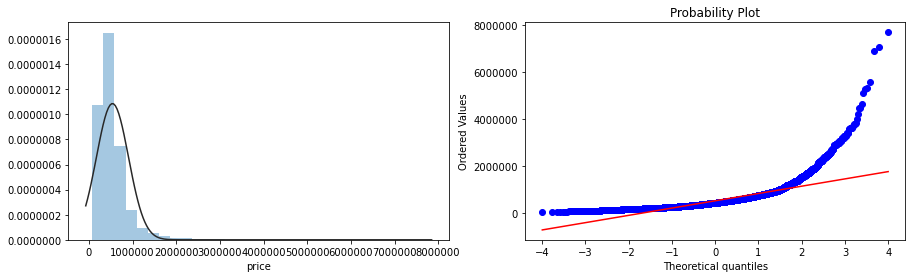

In [17]:
#histogram and normal probability plot


# histogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.distplot(df_clean['price'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df_clean['price'], plot=ax2)
ax1.ticklabel_format(useOffset=False, style='plain')
ax2.ticklabel_format(useOffset=False, style='plain')

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df_clean['price'].skew()) # Data is highly skewed
print("Kurtosis: %f" % df_clean['price'].kurt()) # leptokurtic (>3)

### Results
The data in the variable `price` is highly right-skewed and does not follow a normal distribution as shown in the histogram and QQ-plot. This may result in a high level of heteroskedasticity because there are many orders of magnitude between the lowest and highest sale price. In other words, the variance is changing porportionally with the variable.

## Residual plot

In [18]:
# Residual plot
def residual_plot(data, X, Y):
    x = data[X]
    y = data[Y]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    ax1.scatter(x, y)
    m, b = np.polyfit(x, y, 1) # regression line
    ax1.plot(x, m*x+b, color='red') # plot regression line
    sns.residplot(x=x, y = y, ax=ax2) # residual plot
    ax1.title.set_text(f'Scatterplot: {X} versus {Y}')
    ax2.title.set_text(f'Residual plot: {X} versus {Y}')
    #fig.supylabel(f'log {Y}')
    #fig.supxlabel(f'{X}')
    plt.ylabel('residual')
    plt.xlabel('')
    


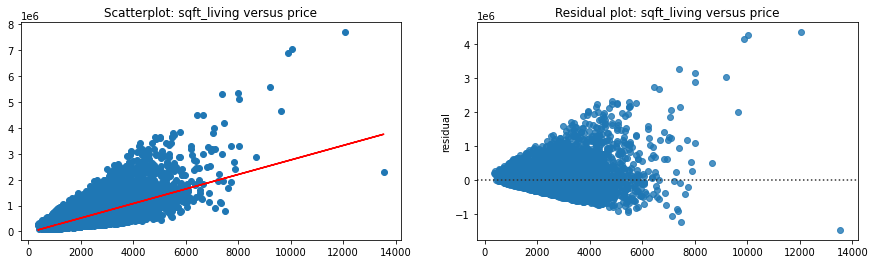

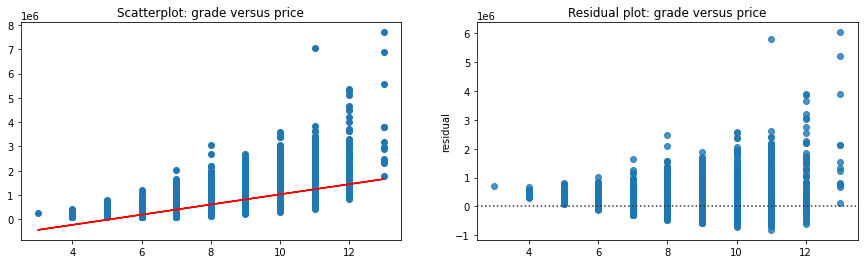

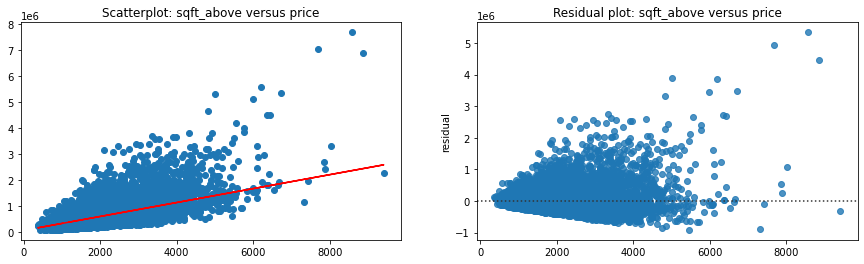

In [19]:
# Residual plot
residual_plot(df_clean, 'sqft_living', 'price')
residual_plot(df_clean, 'grade', 'price')
residual_plot(df_clean, 'sqft_above', 'price')

### Results
The fitted line plot on top of the scatterplot indicates that the relationship is not linear. The fan shape in the residual plot indicates that there is a high level of heteroskedasticity which would violate the assumptions of ordinary least squares regression. To fix this the `price` variable and variables associated with square feet will be log transformed.

Skewness: 0.431004
Kurtosis: 0.691049


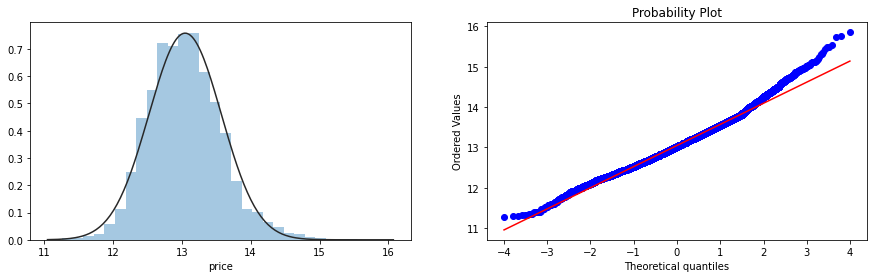

In [20]:
# log transform price data
df_clean['price'] = np.log(df_clean['price'])

# histogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.distplot(df_clean['price'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df_clean['price'], plot=ax2)

## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df_clean['price'].skew()) # Data is not skewed
print("Kurtosis: %f" % df_clean['price'].kurt()) # leptokurtic (>3)

In [21]:
# Transform the rest of the continuous right-skewed variables
df_clean['sqft_living'] = np.log(df_clean['sqft_living'])
df_clean['sqft_above'] = np.log(df_clean['sqft_above'])
df_clean['sqft_lot15'] = np.log(df_clean['sqft_lot15'])
df_clean['sqft_lot'] = np.log(df_clean['sqft_lot'])
df_clean['sqft_living15'] = np.log(df_clean['sqft_living15'])

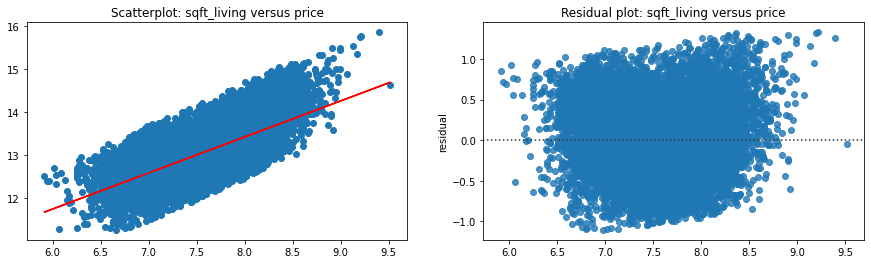

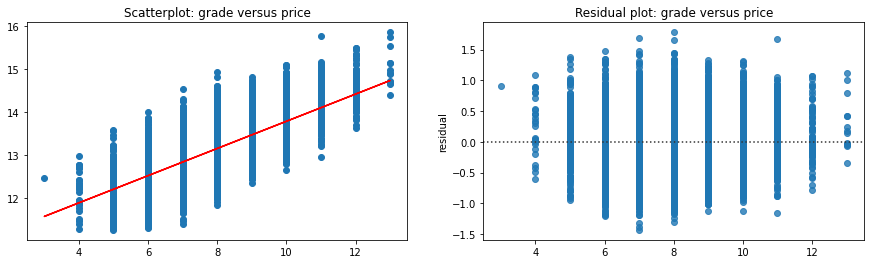

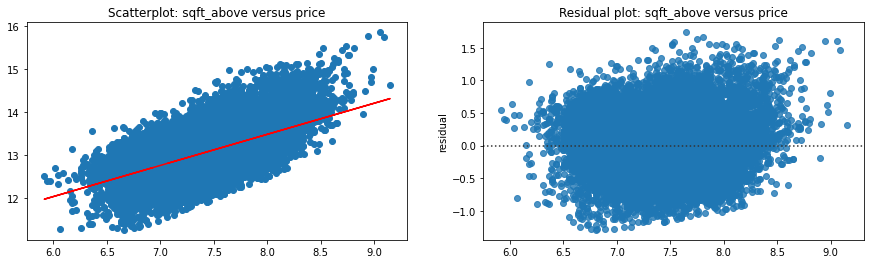

In [22]:
# Residual plot
residual_plot(df_clean, 'sqft_living', 'price')
residual_plot(df_clean, 'grade', 'price')
residual_plot(df_clean, 'sqft_above', 'price')

##### Residual plot results
After log transforming sale price and sqft data, the residual plot has a random pattern which indicates it meets the homoskedasticity assumption for ordinary least square regression.

### Linear Regression Helper Function

In [61]:
def lin_reg_model(data, formula, model_name):  
    '''
    Input:
        - clean housing data
        - regression formula in R-style
        - model name (ex. Model 1, Model 2)
    Output:
        - OLS summary
        - Residual QQ-plot
        - Dataframe of testing data predictions and prediction interval
        - OLS model object
        - Prediction interval    
    '''
    # Make Test-train split
    y = data['price'] # outcome data
    X = data.drop('price', axis=1) # predictors
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2) #80% training
    train = pd.concat([y_train, X_train], axis=1)
    test = pd.concat([y_test, X_test], axis=1)
    
    # Fit model
    #model = smf.ols(formula=formula, data=df_clean).fit()
    model = smf.ols(formula=formula, data=test).fit()
        
    # predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    
    # Calculate predictions, pi_low, pi_up
    sum_errs = np.sum((y_test - y_hat_test) **2)
    stdev = np.sqrt(1/(len(y_test)-2) * sum_errs)
    interval = 1.96 * stdev # Prediction interval
    PI_low, PI_up = y_hat_test - interval, y_hat_test + interval

    # residuals
    resid_model = model.resid

    # Root Mean Squared Error
    train_mse = mean_squared_error(y_train, y_hat_train, squared=False)
    test_mse = mean_squared_error(y_test, y_hat_test, squared=False)
    
    d = {'actual': y_test, 'predicted': y_hat_test, 'residual': resid_model, 'pi_low': PI_low, 'pi_up': PI_up}
    df = pd.DataFrame(data = d)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    
    # Fitted value residual plot
    #sns.residplot(x=y_hat_test, y = resid_model, ax=ax1) # residual plot
    
    sns.regplot(x=y_hat_test, y = resid_model, ax=ax[0])
    ax[0].set(ylabel='residuals',xlabel='fitted values')
    #ax2.title.set_text(f'Residual plot: {X} versus {Y}')
    #fig.supylabel(f'log {Y}')
    #fig.supxlabel(f'{X}')
    #plt.ylabel('residual')
    
    # Plot residual qq-plot
    sm.graphics.qqplot(resid_model, dist=stats.norm, line='45', fit=True, ax=ax[1])
    plt.show() # see https://github.com/statsmodels/statsmodels/issues/5493 for bug
    #fig.suptitle(f'{model_name} Residual QQ plot')
    
    print(model.summary())
    print('\n')
    print('Train Root Mean Squarred Error:', train_mse)
    print('Test Root Mean Squarred Error:', test_mse)
    print('Prediction interval:', interval)
    
    return df, model, interval

## Model 1 (M1)

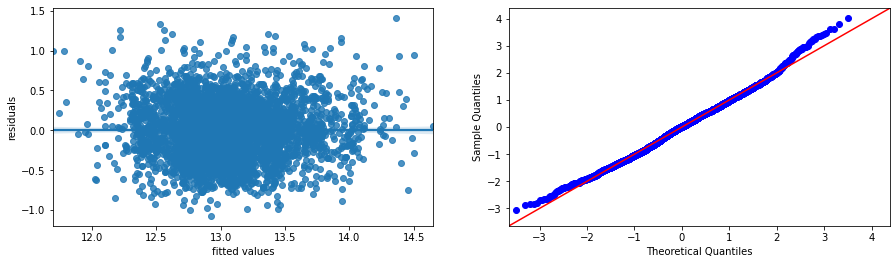

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     1765.
Date:                Thu, 21 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:53:32   Log-Likelihood:                -1591.0
No. Observations:                4320   AIC:                             3190.
Df Residuals:                    4316   BIC:                             3215.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.7528      0.116     75.603      

In [62]:
# Model 1
model_1_features = corr_with_price['Features'].values # Highest correlated features
formula_1 = 'price ~' + '+'.join(model_1_features)
model_1_results, model_1_reg, model_1_pi = lin_reg_model(df_clean, formula_1, 'Model 1')

#### Interpretation
The p-values indicate that each of these variables have a statistical significant relationship with the dependent variable, but the r-squared value is low at 0.55. For a predictive model the R-squared needs to be higher.

In [25]:
#Backward Elimination
def backward_elimination(X, y):
    '''
    Source: Source https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
    Feed all the possible features to the model at first. We check 
    the performance of the model and then iteratively remove the worst 
    performing features one by one till the overall performance of the 
    model comes in acceptable range. The performance metric used here to 
    evaluate feature performance is pvalue. If the pvalue is above 0.05 
    then we remove the feature, else we keep it.
    '''
    X = df_clean.copy()
    X.drop(y.columns, axis=1, inplace=True)
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    return cols



In [26]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement',
       'zipcode', 'sqft_living15', 'sqft_lot15', 'home_age', 'yr_since_reno'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     401.4
Date:                Thu, 21 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:11:14   Log-Likelihood:                 1321.1
No. Observations:                4320   AIC:                            -2480.
Df Residuals:                    4239   BIC:                            -1964.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0154      0.106     66.442

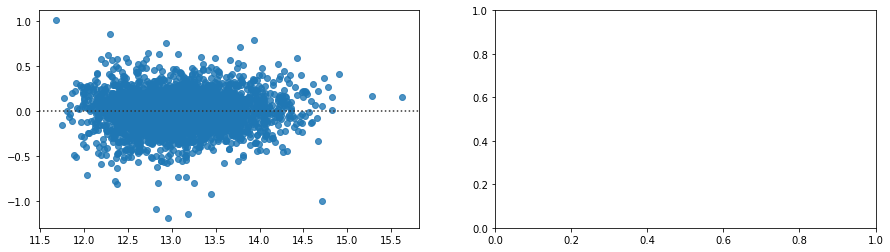

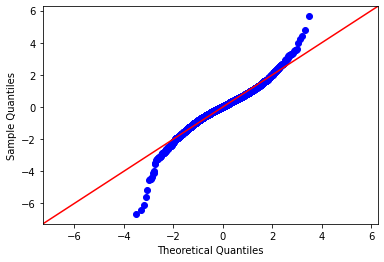

In [27]:
model_2_features = backward_elimination(df_clean, df_clean[['price']])
formula_2 = 'price ~' + '+'.join(model_2_features)
model_2_results, model_2_reg, model_2_pi = lin_reg_model(df_clean, formula_2, 'Model 2')

#### Interactive Effects

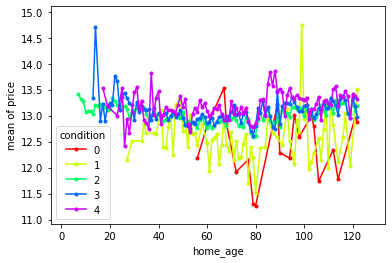

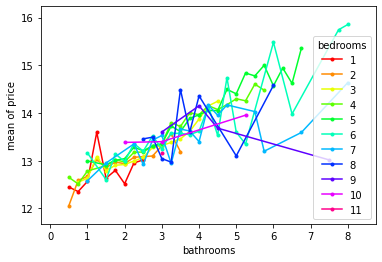

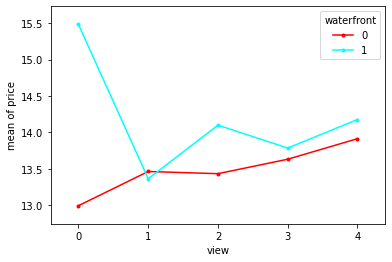

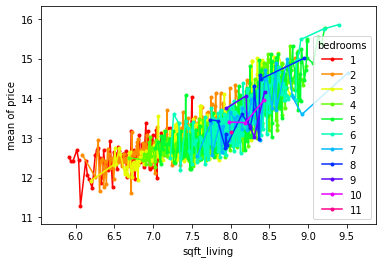

In [28]:
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot

# Interaction of home age and condition
fig1 = interaction_plot(df_clean['home_age'], df_clean['condition'], df_clean['price'])

# Interaction of bathrooms and bedrooms
fig2 = interaction_plot(df_clean['bathrooms'], df_clean['bedrooms'], df_clean['price'])

# interaction of view and waterfront
fig3 = interaction_plot(df_clean['view'], df_clean['waterfront'], df_clean['price'])

# Interaction of sqft_living and bedrooms
fig4 = interaction_plot(df_clean['sqft_living'], df_clean['bedrooms'], df_clean['price'])

##### Interaction Effects Results
On an interaction plot, parallel lines indicate that there is no interaction effect while different slopes suggest that one might be present. Home age and condition, bathrooms and bedrooms, and sqft_living and bedrooms each show interaction effects. This means a third variable influences the relationship between a dependent and independent variable. The relationship changes depending on the value of the third variable. The p-value of the intraction effect of bedrooms and bathrooms is greater than 0.05 which indicates it is not a significant effect.

View and waterfront shows a slight interactive effect but only for view of 1 with no waterfront property. This may because the view variable is measuring the view of the mountains in Washington and not the view of a waterfront property.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     874.4
Date:                Thu, 21 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:11:15   Log-Likelihood:                -1237.7
No. Observations:                4320   AIC:                             2493.
Df Residuals:                    4311   BIC:                             2551.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.6857 

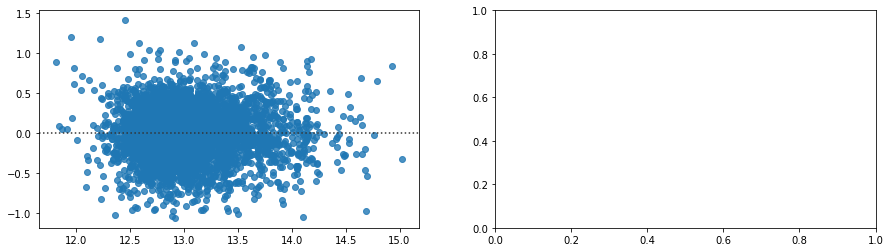

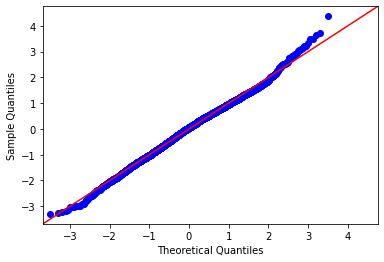

In [29]:
formula_3 = 'price ~' + '+'.join(model_1_features) + '+ home_age*condition + sqft_living*bedrooms'
model_3_results, model_3_reg, model_3_pi = lin_reg_model(df_clean, formula_3, 'Model 3')

### Compare models

## Prediction
A prediction interval (PI) is the range where a single new observation is likely to fall given specific values of the indpendent variables. Can use to assess if the predicitons are sufficiently precise to satisfy my requirement.

In [30]:
def price_predictor(model_no, new_data, pi, logged=True):
    '''
    This function takes in a model and Pandas series object and returns
    an estimated price range for the house to be listed.
    
    Model 1: price ~ ln(sqft_living) + ln(sqft_above) + grade
    
    Model 2: price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+
                     view+condition+grade+sqft_above+basement+sqft_living15+sqft_lot15+
                     home_age+yr_since_reno+zipcode
                    
    Model 3: price ~ sqft_living+grade+sqft_above+ home_age*condition + sqft_living*bedrooms
    '''
    #intercept = model_no.params['Intercept']
    
    # Transform the new data
    #if not logged:
    #    new_data_trans = pd.Series()
    #    for row in new_data.index:
    #        if 'sqft' in row:
    #            new_data_trans[row] = np.log(new_data[row])
    #        else:
    #            new_data_trans[row] = new_data[row]
    #else:
    #    new_data_trans = new_data
        
    price_ln = model_no.predict(new_data).values[0]
    price = round(np.exp(price_ln))
    price_low = round(np.exp(price_ln - pi))
    price_up = round(np.exp(price_ln + pi))
    
    return f'Predicted price: {price}, range: {price_low} - {price_up}'

In [31]:
data = df_clean.sample().squeeze() #8677 zip:98055, #5580 zip: 98031, #18610 zip: 98027

In [33]:
data = df_clean.iloc[8677]

price            12.611538
bedrooms          4.000000
bathrooms         2.500000
sqft_living       7.803843
sqft_lot          9.097396
                   ...    
zipcode_98177     0.000000
zipcode_98178     0.000000
zipcode_98188     0.000000
zipcode_98198     0.000000
zipcode_98199     0.000000
Name: 8677, Length: 85, dtype: float64

In [34]:
# Model 1 prediction function
data_new = data.drop('price')
print(price_predictor(model_1_reg, data_new, model_1_pi, True))
sale_price = round(np.exp(data['price']))
print(f'Actual sale price: {sale_price}')

Predicted price: 525244.0, range: 264615.0 - 1042573.0
Actual sale price: 300000.0


In [35]:
# Model 2 Prediction function
print(price_predictor(model_2_reg, data_new, model_2_pi, True))
print(f'Actual sale price: {sale_price}')

Predicted price: 322854.0, range: 227650.0 - 457872.0
Actual sale price: 300000.0


In [36]:
# Model 3 prediction function
print(price_predictor(model_3_reg, data_new, model_3_pi, True))
print(f'Actual sale price: {sale_price}')

Predicted price: 494805.0, range: 263068.0 - 930680.0
Actual sale price: 300000.0
